In [1]:
import ee
import geemap
import pandas as pd
import dtale
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold,train_test_split
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score,mean_absolute_percentage_error
import glob
import dask.dataframe as dd
from tpot import TPOTRegressor
import xarray as xr
from scipy import stats
from sklearn.svm import SVR
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import plot_partial_dependence
from warnings import filterwarnings
filterwarnings('ignore')
import plotly
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import plotly.express as px
import chart_studio.plotly as py
import folium
from folium.plugins import HeatMap
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected = True)
from folium.plugins import FastMarkerCluster
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import os
from sklearn.inspection import permutation_importance

/Users/mdnhuda/opt/anaconda3/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning:




In [2]:
Map_S5P = geemap.Map()
Map_S5P

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [3]:
# Create a common region of interest
roi = ee.Geometry.Polygon([[[-121.39140625, 35.650331512181495],
          [-121.39140625, 30.687240701629882],
          [-112.7341796875, 30.687240701629882],
          [-112.7341796875, 35.650331512181495]]])

In [4]:
# Data COllection for July
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")


In [5]:
Map_S5P_sep = geemap.Map()
Map_S5P_sep

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [6]:
# Data COllection for September
image_S5P_sep = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P_sep = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P_sep.addLayer(image_S5P_sep, vis_params_S5P_sep, "Sentinel-5P TROPOMI NO2")


image_LANDSAT8_sep = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-09-01', '2018-09-30') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8_sep = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P_sep.addLayer(image_LANDSAT8_sep, vis_params_L8_sep, "Landsat-8")


In [7]:
#traing data for July
ground_truth= image_LANDSAT8.addBands(image_S5P)

# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [8]:
#traing data for September
ground_truth_sep= image_LANDSAT8_sep.addBands(image_S5P_sep)

# Make the training dataset.
points_sep = ground_truth_sep.sample(**{
    'region': ground_truth_sep.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P_sep.addLayer(points_sep, {}, 'training', False)

In [9]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol
0,1395.0,3167.0,3113.0,1666.0,2308.0,2840.0,3350.0,3945.0,3605.0,0.000079,96
1,4002.0,2844.5,2838.0,4097.0,4385.5,4665.0,5402.0,4689.5,3557.5,0.000071,52
2,890.5,3096.5,3050.0,1063.5,1541.5,2128.5,2917.5,3438.5,2840.0,0.000082,96
3,2681.5,2916.5,2897.5,2825.0,3037.5,3225.0,3959.0,3884.5,3243.5,0.000075,52
4,1755.5,2725.0,2714.0,1633.5,2076.0,1917.5,1791.0,2131.0,2029.5,0.000064,38
...,...,...,...,...,...,...,...,...,...,...,...
4408,1328.0,3081.0,3024.0,1482.0,1907.0,2339.0,2971.0,3400.0,2791.0,0.000078,80
4409,107.0,3048.0,3020.0,174.0,417.0,325.0,2486.0,1082.0,535.0,0.000079,96
4410,798.0,3122.0,3059.5,989.5,1406.0,1756.0,2615.0,3158.5,2631.0,0.000081,160
4411,518.0,2922.0,2912.5,476.0,350.5,297.5,288.5,273.0,230.0,0.000063,68


In [10]:
#df_sep.to_csv ('LandSat8_S5_Los_Angeles_Sep_5000_Points.csv', index = False, header=True)

In [11]:
df_sep = geemap.ee_to_pandas(points_sep)
df_sep

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol
0,1364.0,3148.0,3126.0,1596.0,2236.0,2766.0,3228.0,3867.0,3656.0,0.000065,96
1,495.0,3092.0,3079.0,614.5,975.5,1292.0,2522.0,2920.0,2268.5,0.000059,96
2,1112.0,3170.0,3142.0,1285.0,1808.5,2419.5,3130.0,3898.0,3605.5,0.000071,96
3,327.5,3099.5,3091.5,448.0,702.5,843.0,1799.0,1452.0,1072.0,0.000061,96
4,6144.0,2865.5,2864.0,6212.5,6253.0,6396.0,6595.5,5521.0,4273.0,0.000054,8
...,...,...,...,...,...,...,...,...,...,...,...
4407,1116.5,3150.0,3123.0,1282.0,1718.5,2151.5,2688.0,3151.0,2733.0,0.000066,96
4408,12.0,3000.0,2987.0,94.5,324.0,251.0,2175.5,940.5,470.0,0.000068,96
4409,772.5,3175.5,3133.0,945.0,1388.0,1697.5,2451.0,3134.5,2642.0,0.000063,81
4410,2782.0,2894.0,2887.0,2748.0,2581.0,2596.0,2673.0,2736.5,2653.0,0.000054,8


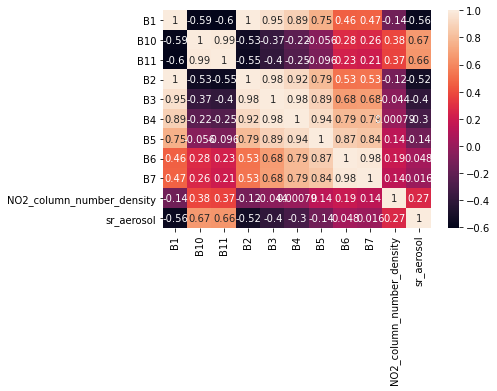

In [12]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

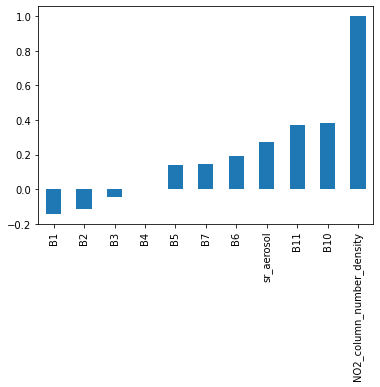

In [13]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

It looks like B1, B2, B3, B4, B10, B11, and sr-aerosol strongly correlate with the NO2 values. It will be good to see how do they perform in a fitted model.

## ! Notes to Toyon !

- Can you run a multivariate regression model for this data, and document p-values?
- Can you run a machine learning model (e.g random forest/GBM) to fit this data? Document the feature importance. You can divide the data into train and test to see how well it performs within the month. 
- Can you test it on a different month (September 2018)? To see the divergence.
- Can you try generating the similar dataset for June 2018 using Sentinel-2 and Sentinel-5P data?
- Side note: we may have to generate additional spatial and temporal values (month, day of week, etc.) in the future to develop more precise models.

In [14]:
dtale.show(df)

In [15]:
df.isnull().sum()

B1                           0
B10                          0
B11                          0
B2                           0
B3                           0
B4                           0
B5                           0
B6                           0
B7                           0
NO2_column_number_density    0
sr_aerosol                   0
dtype: int64

In [16]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [17]:
X_sep=df_sep.drop('NO2_column_number_density',axis=1).values
y_sep=df_sep['NO2_column_number_density'].values

X_train_sep, X_test_sep, y_train_sep, y_test_sep = train_test_split(X_sep, y_sep, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train_sep=scaler.fit_transform(X_train_sep)
X_test_sep=scaler.transform(X_test_sep)

In [18]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
model = TPOTRegressor(generations=4, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Optimization Progress:   0%|          | 0/250 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.681774864110596e-06

Generation 2 - Current best internal CV score: -4.681774864110596e-06

Generation 3 - Current best internal CV score: -4.681774864110596e-06

Generation 4 - Current best internal CV score: -4.6614591859547965e-06

Best pipeline: RandomForestRegressor(PCA(MinMaxScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), iterated_power=9, svd_solver=randomized), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
Training Accuracy : -0.000
Test Accuracy : -0.000


Warning: xgboost.XGBRegressor is not available and will not be used by TPOT.

Generation 1 - Current best internal CV score: -4.681774864110596e-06

Generation 2 - Current best internal CV score: -4.681774864110596e-06

Generation 3 - Current best internal CV score: -4.681774864110596e-06

Generation 4 - Current best internal CV score: -4.6614591859547965e-06

## Best pipeline: RandomForestRegressor(PCA(MinMaxScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), iterated_power=9, svd_solver=randomized), bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
## TPOTRegressor(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
              generations=4, n_jobs=-1, population_size=50, random_state=42,
              scoring='neg_mean_absolute_error', verbosity=2)

In [241]:
#model.export('NO2_Prediction_KR_Toyon_July_September_LandSat8_S5_Los_Angeles_tpot_best_model.py')

In [242]:
#from sklearn.ensemble import ExtraTreesRegressor
model = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=7, min_samples_split=20, n_estimators=100)
model.fit(X_train, y_train)
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.696
Test Accuracy : 0.371


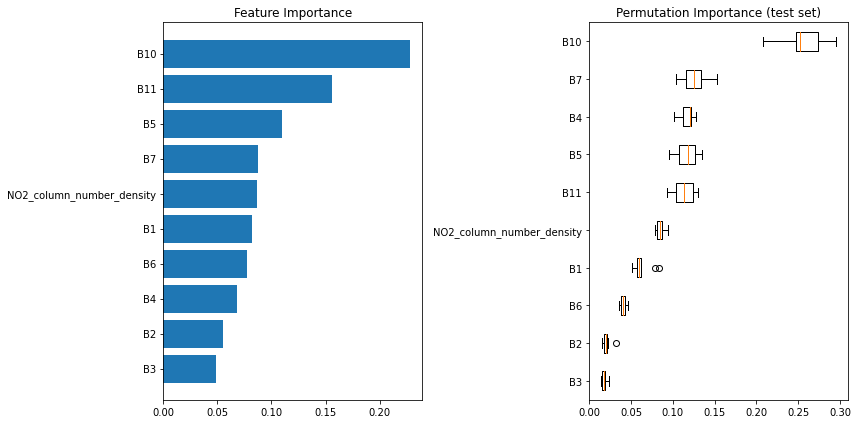

In [243]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Mean Squared Error = 3.1710482948989196e-10
Mean absolute percentage error = 0.22468923824492773


Text(0, 0.5, 'NO2_column_number_density')

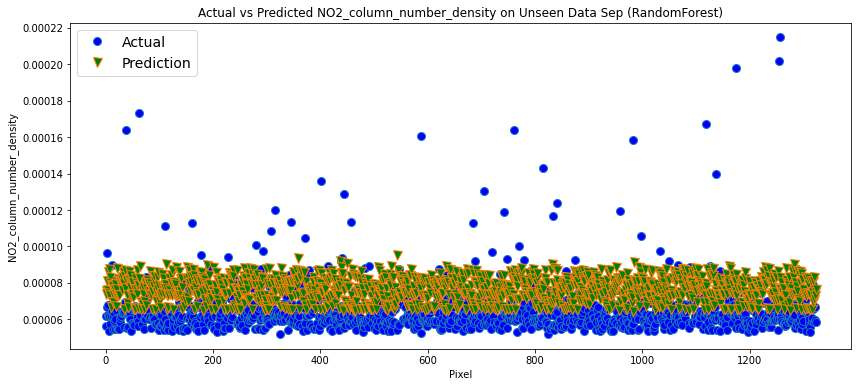

In [244]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Text(0, 0.5, 'NO2_column_number_density')

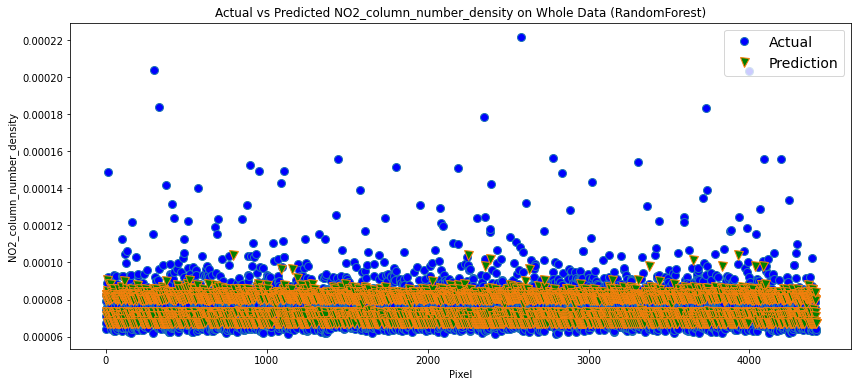

In [245]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (RandomForest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

## Additional Methods follows below

In [246]:
model_params = {
    'svm': {
        'model': SVR(gamma='auto'),
        'params' : {
            'C': [10,20,50],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [5,10,15]
        }
    },
}

In [247]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_score

,model,best_score,best_params
0,svm,-30.264597,"{'C': 10, 'kernel': 'rbf'}"
1,random_forest,0.425977,{'n_estimators': 15}


In [248]:
#Rainforest Regression
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15)
model.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15)

In [249]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.415
Test Accuracy : 0.293


Mean Squared Error = 1.1455471313962305e-10
Mean absolute percentage error = 0.0886525763257143


Text(0, 0.5, 'NO2_column_number_density')

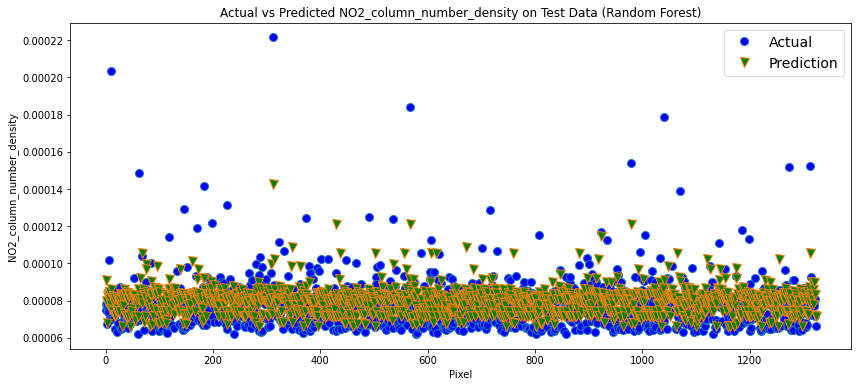

In [250]:
prediction=model.predict(X_test)
MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

Mean Squared Error = 3.539465782330978e-10
Mean absolute percentage error = 0.2474144176807455


Text(0, 0.5, 'NO2_column_number_density')

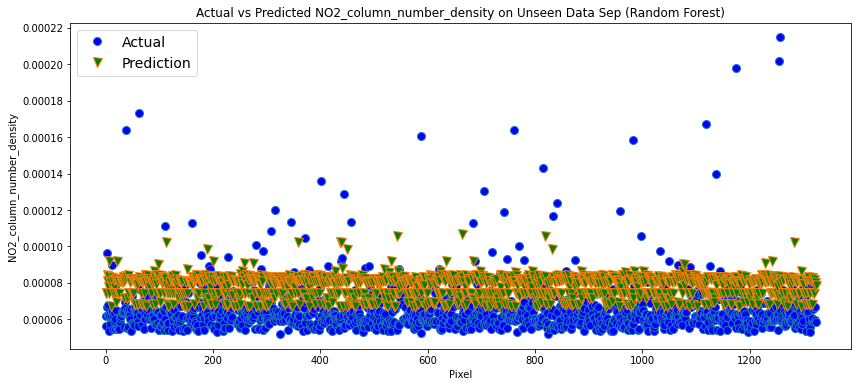

In [251]:
prediction_sep=model.predict(X_test_sep)
MSE=mean_squared_error(y_test_sep,prediction_sep)
print("Mean Squared Error =",MSE)

MAPE=mean_absolute_percentage_error(y_test_sep,prediction_sep)
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test_sep,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction_sep,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Unseen Data Sep (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [252]:
NO2_column_number_density=df['NO2_column_number_density']

Text(0, 0.5, 'NO2_column_number_density')

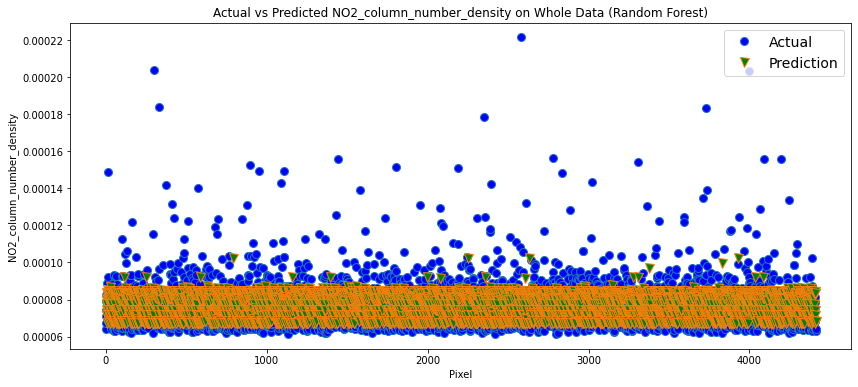

In [254]:
fig = plt.figure(figsize=(14,6))
plt.plot(NO2_column_number_density,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(all_prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Whole Data (Random Forest)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

In [255]:
#X.rename(index={0: "B1", 1: "B10", 2: "B11", 3: "B2",4: "B3", 5: "B4", 6: "B5", 7: "B6", 8: "B7"})

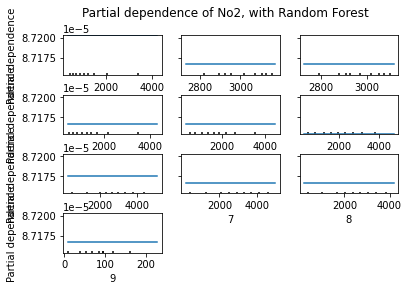

In [256]:
display = plot_partial_dependence(
       model, X, features=[0,1,2,3,4,5,6,7,8,9])

display.figure_.suptitle('Partial dependence of No2, with Random Forest')
display.figure_.subplots_adjust(hspace=0.5)

In [257]:
logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          1.412e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:30:42   Log-Likelihood:                          30782.
No. Observations:                3089   AIC:                                 -6.154e+04
Df Residuals:                    3079   BIC:                                 -6.148e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Start Mutlti-OutPut Regression Here! 
## With Target Output  
## y=  ['NO2_column_number_density','tropospheric_NO2_column_number_density']

In [258]:
image_S5P = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('ALGORITHM_VERSION') \
    .select('NO2_column_number_density','tropospheric_NO2_column_number_density') \
    .median() \
    .clip(roi)

vis_params_S5P = {
    'min': 0,
    'max': 0.0002,
    'bands': ['NO2_column_number_density'],
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

Map_S5P.addLayer(image_S5P, vis_params_S5P, "Sentinel-5P TROPOMI NO2")

In [259]:
image_LANDSAT8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-07-01', '2018-07-31') \
    .sort('CLOUD_COVER') \
    .select('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'sr_aerosol') \
    .median() \
    .clip(roi)

vis_params_L8 = {
    'min': 0,
    'max': 3000,
    'bands': ['B5', 'B4', 'B3']
}


Map_S5P.addLayer(image_LANDSAT8, vis_params_L8, "Landsat-8")

In [260]:
ground_truth= image_LANDSAT8.addBands(image_S5P)

In [261]:
# Make the training dataset.
points = ground_truth.sample(**{
    'region': ground_truth.geometry(),
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True  # Set this to False to ignore geometries
})

Map_S5P.addLayer(points, {}, 'training', False)

In [262]:
df = geemap.ee_to_pandas(points)
df

,B1,B10,B11,B2,B3,B4,B5,B6,B7,NO2_column_number_density,sr_aerosol,tropospheric_NO2_column_number_density
0,1395.0,3167.0,3113.0,1666.0,2308.0,2840.0,3350.0,3945.0,3605.0,0.000079,96,0.000022
1,4002.0,2844.5,2838.0,4097.0,4385.5,4665.0,5402.0,4689.5,3557.5,0.000071,52,0.000022
2,890.5,3096.5,3050.0,1063.5,1541.5,2128.5,2917.5,3438.5,2840.0,0.000082,96,0.000029
3,2681.5,2916.5,2897.5,2825.0,3037.5,3225.0,3959.0,3884.5,3243.5,0.000075,52,0.000021
4,1755.5,2725.0,2714.0,1633.5,2076.0,1917.5,1791.0,2131.0,2029.5,0.000064,38,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...
4408,1328.0,3081.0,3024.0,1482.0,1907.0,2339.0,2971.0,3400.0,2791.0,0.000078,80,0.000021
4409,107.0,3048.0,3020.0,174.0,417.0,325.0,2486.0,1082.0,535.0,0.000079,96,0.000025
4410,798.0,3122.0,3059.5,989.5,1406.0,1756.0,2615.0,3158.5,2631.0,0.000081,160,0.000025
4411,518.0,2922.0,2912.5,476.0,350.5,297.5,288.5,273.0,230.0,0.000063,68,0.000016


In [263]:
#df.to_csv ('LandSat8_S5_Los_Angeles_July_Multi_5000_Points.csv', index = False, header=True)

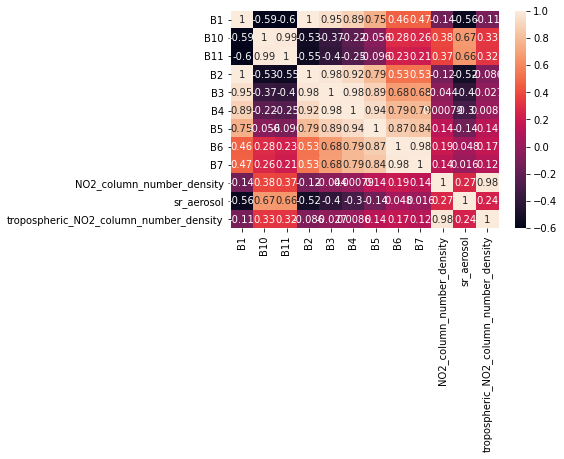

In [264]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

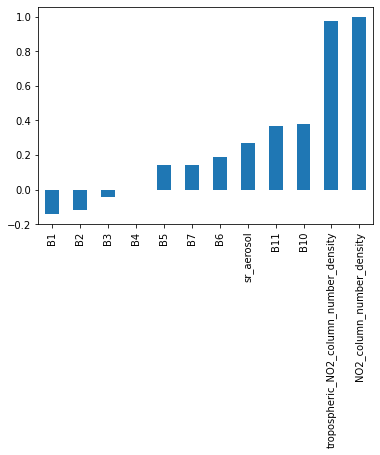

In [265]:
df.corr()['NO2_column_number_density'].sort_values().plot(kind='bar')

In [266]:
X=df.drop(['NO2_column_number_density','tropospheric_NO2_column_number_density'],axis=1).values
y=df[['NO2_column_number_density','tropospheric_NO2_column_number_density']].values


In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Linear Regression for Multioutput Regression

7.973797609290122e-05
Mean Squared Error = 1.2729103783274948e-10
Mean absolute percentage error = 0.07654260126274669
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          1.412e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:35:06   Log-Likelihood:                          30782.
No. Observations:                3089   AIC:                                 -6.154e+04
Df Residuals:                    3079   BIC:                                 -6.148e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
 

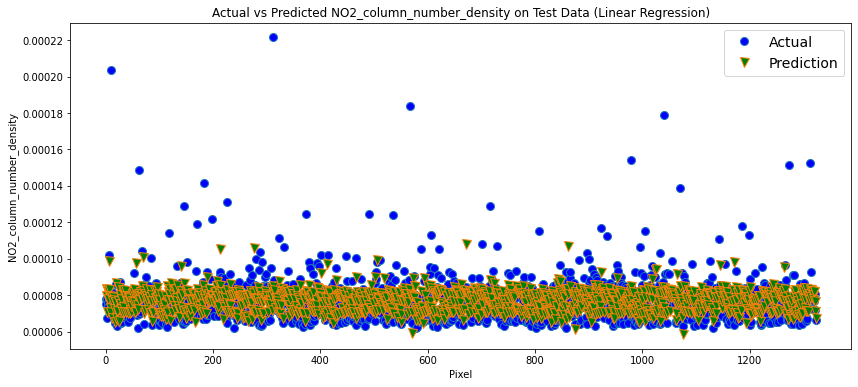

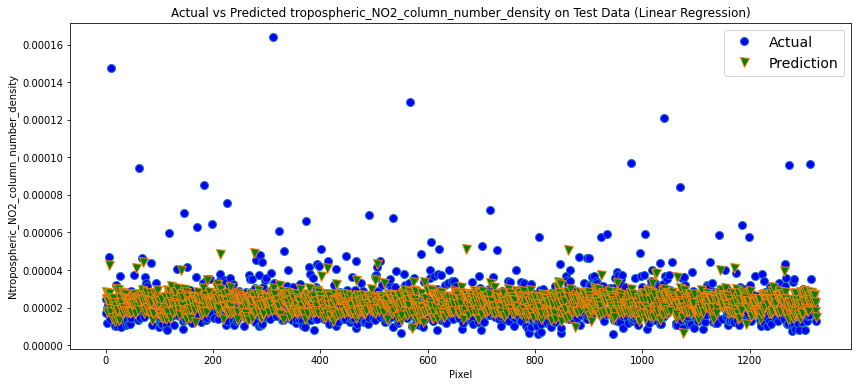

In [268]:
model = LinearRegression()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

##
MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)


fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,1],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,1],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted tropospheric_NO2_column_number_density on Test Data (Linear Regression)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('Ntropospheric_NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [269]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.248
Test Accuracy : 0.199


# k-Nearest Neighbors for Multioutput Regression

7.719756151653731e-05
Mean Squared Error = 1.1344640727492014e-10
Mean absolute percentage error = 0.06545563606513582
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          1.412e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:35:07   Log-Likelihood:                          30782.
No. Observations:                3089   AIC:                                 -6.154e+04
Df Residuals:                    3079   BIC:                                 -6.148e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
 

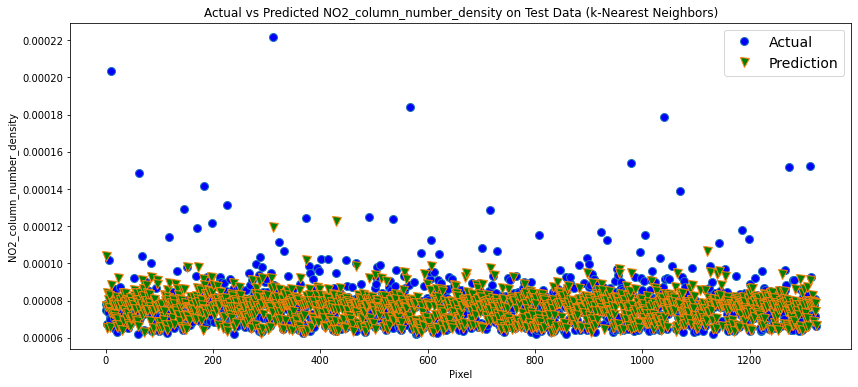

In [270]:
# define model
model = KNeighborsRegressor()
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (k-Nearest Neighbors)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [271]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.499
Test Accuracy : 0.278


# Decision Tree for Multioutput Regression

7.852038175998094e-05
Mean Squared Error = 1.185525231825627e-10
Mean absolute percentage error = 0.0742995661235715
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                          1.412e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:35:08   Log-Likelihood:                          30782.
No. Observations:                3089   AIC:                                 -6.154e+04
Df Residuals:                    3079   BIC:                                 -6.148e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
   

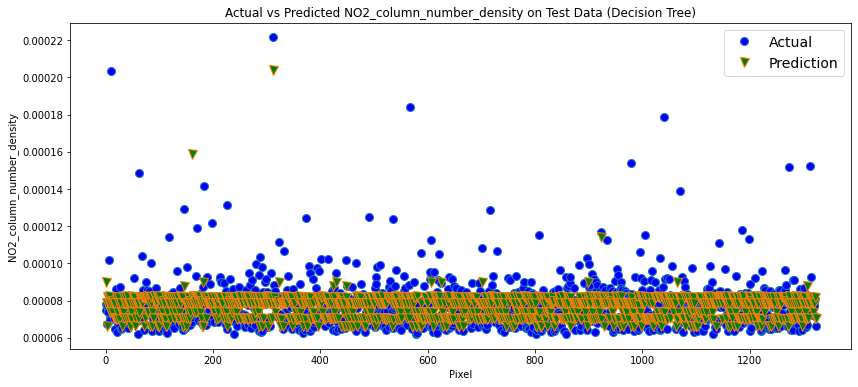

In [272]:
# define model
model = DecisionTreeRegressor(max_depth=8,
                           min_samples_split=5,
                           max_leaf_nodes=20)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
print(prediction[0,0])

MSE=mean_squared_error(y_test[:,0],prediction[:,0])
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test[:,0],prediction[:,0])
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test[:,0],marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction[:,0],marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train[:,0],X_train)
result=logit_model.fit()
print(result.summary())

In [273]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.447
Test Accuracy : 0.252


In [274]:
X=df.drop('NO2_column_number_density',axis=1).values
y=df['NO2_column_number_density'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

Mean Squared Error = 1.4195523882101614e-11
Mean absolute percentage error = 0.02360256065234607
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          3.524e+04
Date:                Wed, 30 Jun 2021   Prob (F-statistic):                        0.00
Time:                        18:35:15   Log-Likelihood:                          32321.
No. Observations:                3089   AIC:                                 -6.462e+04
Df Residuals:                    3078   BIC:                                 -6.455e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef  

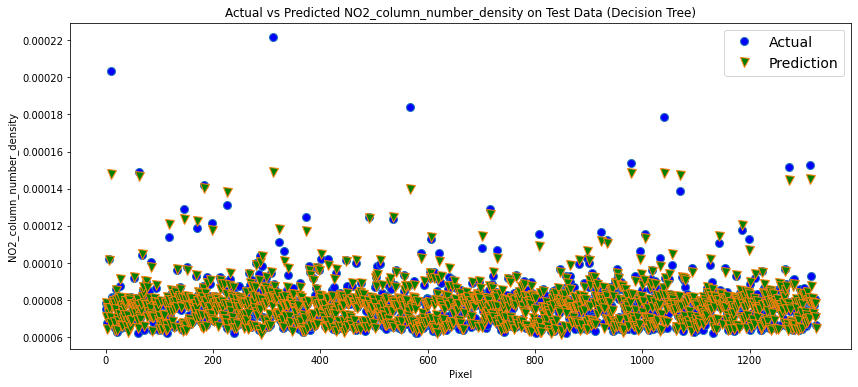

In [275]:
model = GradientBoostingRegressor(alpha=0.85, learning_rate=0.5, loss='lad', max_depth=15, max_features=0.9500000000000001,
                                min_samples_leaf=12, min_samples_split=7, n_estimators=100, subsample=0.6500000000000001)
# fit model
model.fit(X_train,y_train)
# make a prediction
prediction=model.predict(X_test)
# summarize prediction
#print(prediction[0,0])

MSE=mean_squared_error(y_test,prediction)
print("Mean Squared Error =",MSE)
MAPE=mean_absolute_percentage_error(y_test,prediction)
print("Mean absolute percentage error =",MAPE)

fig = plt.figure(figsize=(14,6))
plt.plot(y_test,marker="o", ms = 8, mfc = 'b', linestyle='None',label='Actual')
plt.plot(prediction,marker="v", ms = 9,linestyle='None', mfc = 'g',label='Prediction')
plt.title('Actual vs Predicted NO2_column_number_density on Test Data (Decision Tree)')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Pixel')
plt.ylabel('NO2_column_number_density')

logit_model=sm.OLS(y_train,X_train)
result=logit_model.fit()
print(result.summary())

In [276]:
print('Training Accuracy : %.3f'% model.score(X_train,y_train))

print('Test Accuracy : %.3f'%model.score(X_test,y_test))

Training Accuracy : 0.976
Test Accuracy : 0.912
